In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
import glob
# import pickle
import pylab as plt

from matplotlib.pyplot import get_cmap
%matplotlib inline  

src_dir = os.path.abspath(os.path.join(os.pardir,'src'))
sys.path[0] = src_dir



# Data

In [2]:
path_read = '../data_filter/'
fname_data = 'ipip300-no0_arr_pd_neoac_score-1.npy'
filename= os.path.join(path_read,fname_data)
label = fname_data.split('.')

list_doms = ['N','E','O','A','C']
dict_dom_name = {
    'N':'Neuroticism',
    'E':'Extraversion',
    'O':'Openness',
    'A':'Agreeableness',
    'C':'Conscientiousness'
                }
list_doms_labels = list_doms

In [3]:
## load data   
X = np.load(filename)
P,D = np.shape(X)

## Count the number of respondents in each quadrant

I can resproduce their table.

Coding the types in the same way, our 4 types are among the top 7 quadrants.
Thus, this is consistent.

HOwever, I am not sure whether this analysis necessarily supports their point about the skew, 
because the types also lead to such an observation.

In [4]:
## enumerate all possibilities 00001,00010,..., 11111
from itertools import product
list_s = ['0','1']
list_q = []
for s1,s2,s3,s4,s5 in product(list_s,list_s,list_s,list_s,list_s):
    s = s1+s2+s3+s4+s5
    list_q += [s]
        

In [5]:
## count the number of respondents in each quadrant
list_n = []
for q in list_q:
    s = [int(h) for h in q]
    set_inds = set(np.arange(P))
    for i in range(5):
        if s[i] == 0:
            inds = np.where( X[:,i]<=0 )[0]
        else:
            inds =  np.where( X[:,i]>0 )[0]
        set_inds = set_inds.intersection(set(inds))
    n = len(set_inds) 
    list_n += [n]
#     break

In [6]:
## null model: sampling 5D traitvectors from the skewed marginals
## this is the same as randomizing trait-scores and keeping the marginals fixed
## we average over n_rep (=10) iterations

from analysis.data_sample import data_randomize
n_rep = 10
list_n_r = np.zeros(len(list_q))
list_n2_r = np.zeros(len(list_q))

for i_n_rep in range(n_rep):

    X_r = data_randomize(X)
    list_n_r_tmp = []
    for q in list_q:
        s = [int(h) for h in q]
        set_inds = set(np.arange(P))
        for i in range(5):
            if s[i] == 0:
                inds = np.where( X_r[:,i]<=0 )[0]
            else:
                inds =  np.where( X_r[:,i]>0 )[0]
            set_inds = set_inds.intersection(set(inds))
        n = len(set_inds) 
        list_n_r_tmp += [n]
    list_n_r += np.array(list_n_r_tmp)/n_rep
    list_n2_r += np.array(list_n_r_tmp)**2/n_rep
list_n_r_std = np.sqrt( list_n2_r -  list_n_r**2 )

In [11]:
np.sqrt(5)-1.0

1.2360679774997898

In [21]:
###########
## Setup ##
###########
# number of pt for column in latex-document
fig_width_pt = 510  # single-column:510, double-column: 246; Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.1/72.27 # Convert pt to inches
width_vs_height = (np.sqrt(5)-1.0)/0.8#(np.sqrt(5)-1.0)/2.0 # Ratio of height/width [(np.sqrt(5)-1.0)/2.0]
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = width_vs_height*fig_width  # height in inches
fig_size = [fig_width,fig_height]

# here you can set the parameters of the plot (fontsizes,...) in pt
params = {'backend': 'ps',
          'axes.titlesize':14,
          'axes.labelsize': 14,
#           'text.fontsize': 10,
          'legend.fontsize': 12,
#           'figtext.fontsize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          
          'text.usetex': True,
          'ps.usedistiller' : 'xpdf',
          'figure.figsize': fig_size,
          'text.latex.unicode':True,
          'text.latex.preamble': [r'\usepackage{bm}'],
          
          'xtick.direction':'out',
          'ytick.direction':'out',
          
          'axes.spines.right' : False,
          'axes.spines.top' : False
         }
plt.rcParams.update(params)

set_b = 0.22 # set bottom
set_l = 0.1 # set left
set_r = 0.925 # set right
set_hs = 0.2 # set horizontal space
set_vs = 0.25 # set vertical space

set_ms = 0.0 # set marker size
set_lw = 2.5 # set line width
set_alpha = 0.8

n_std = 2

## set colors
cmap = 'tab10'
cm = plt.get_cmap(cmap)

/home/martin/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


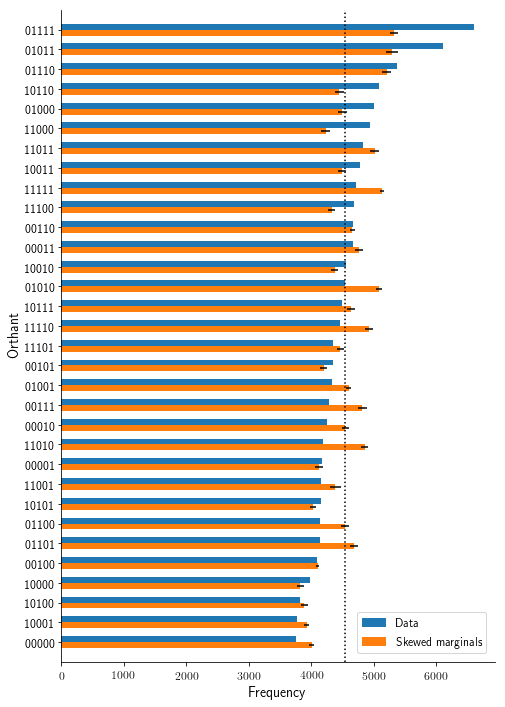

In [37]:
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111)

## sort from lowest counts to highest counts
indsort = np.argsort(list_n)
width = 0.3

## plot data counts
y_ = np.array(list_n)[indsort]
x_ = np.array(list_q)[indsort]
ax.barh(x_,y_,height=width,align='edge',label='Data')

## plot null model counts
y_ = np.array(list_n_r)[indsort]
yerr_ = np.array(list_n_r_std)[indsort]
x_ = np.array(list_q)[indsort]
ax.barh(x_,y_,xerr=yerr_,height=-width,align='edge',label='Skewed marginals')

## plot dotted reference curve
n_avg = P/len(list_q)
ax.plot([n_avg,n_avg],[-1,len(list_q)],ls=':',color='black')

ax.set_xlabel('Frequency')
ax.set_ylabel('Orthant')

ax.set_ylim(-1,len(list_q))

ax.legend(loc='lower right',borderaxespad=0.7)

path_save = '../figures/'
fname_save = 'commentary-katahira_quadrant-count.png'
fname_save = 'commentary-katahira_quadrant-count.svg'

filename = os.path.join(path_save,fname_save)
plt.savefig(filename,dpi=300)

# Interpretation

the question we ask here is the following:

the authors of the comment suggest that the skewness alone can lead to those 'peaks', where there are some quadrants with many more participants.
Looking at the random dataset we can assess how many respsondents we would find in each quadrant only due to the skewness, because the shuffling preserves the marginal distributions and thus the skewness.

Comparing the actual number of respondents with the number of respondents in the shuffled data suggests that there are only few quadrants in which we find many more respondents than we would expect from the skewness.

Coding our types into 0-1 format, we find that all 3 types (the avergae type cannot really be coded in  that scheme) are not only among the top-quadrants, but also only those which habve an excess mass.

# Comparison of our types:

- average: not really clear how to code in the quadrants looking -1, 1
- self-centered: 01000
- reserved: 01011
- role-model: 01111

These 3 are in the top 5 (and among the top-4 for which there is an excess in mass).


# A reminder of our null model

THe null model simulates what the data would look like if all trait scores were indepdnent of each other.
Indeed having skew explains some of the observed effect, but not all; and it certainly gets some quadrants completely wrong.
Therefore, it is important to look at the combination of trait-scores to get the full picture

In [9]:
P

145388